That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [111]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [112]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

In [113]:
fname = '/u/ki/swmclau2/des/PearceMCMC/SHUFFLED_SHAM_wp_ds_rmin_0.5_HOD.hdf5'

In [114]:
f = h5py.File(fname, 'r')

In [115]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [116]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_zheng07_h/PearceWpCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_zheng07_h/PearceDsCosmo.hdf5'],
      dtype='|S61')

In [117]:
fixed_params = fixed_params#[0]

In [118]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_zheng07_h/PearceWpCosmo.hdf5
3
/u/ki/swmclau2/des/Aemulators/ds_zheng07_h/PearceDsCosmo.hdf5
3


In [119]:
chain_pnames = f.attrs['param_names']

In [120]:
n_walkers = f.attrs['nwalkers']

In [121]:
n_burn = 0
chain = f['chain'][n_burn*n_walkers:, :]

In [122]:
rmin = 0#eval(f.attrs['fixed_params'])['rmin']

In [123]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [124]:
print chain.shape, chain.shape[0]/n_walkers

(6664750, 12) 26659


In [125]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [126]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.06741219e-02  1.31551979e-01 -1.39730151e+00  9.97268700e-01
  6.77983853e+01  2.62645864e+00  7.51073844e-01  1.46209094e+01
  1.26025396e+01  5.98760815e-01  8.13628377e-01  5.97927149e-01]


In [127]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [128]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [129]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [130]:
MAP_dict.update(fixed_params)

In [131]:
MAP_dict

{'H0': 67.79838531804509,
 'Neff': 2.626458640874288,
 'alpha': 0.8136283770474042,
 'conc_gal_bias': 0.5979271494065179,
 'logM0': 12.602539580404473,
 'logM1': 14.620909446351,
 'ns': 0.9972687001433669,
 'ombh2': 0.020674121860218678,
 'omch2': 0.13155197876928418,
 'sigma8': 0.7510738435678661,
 'sigma_logM': 0.5987608150431984,
 'w0': -1.3973015147533143,
 'z': 0.0}

In [132]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [133]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [134]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [135]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [136]:
cosmo_params['boxno'] = 1
cosmo_params['realization'] = 1

In [137]:
cat = cat_dict['testbox'](**cosmo_params)#construct the specified catalog!

In [138]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [139]:
cat_val_dict

{'H0': 67.77,
 'Neff': 3.046,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'w0': -1.0}

In [140]:
true_param_dict = cat_val_dict.copy()
#hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
hod_params = {'alpha': 0.95, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.5, 'sigma_logM': 0.2}#sim_info['hod_params']


#hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_param1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [141]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 0.95,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.5,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

In [142]:
true_data = f['data'][()]#.flatten()

In [143]:
true_data = true_data.reshape((2, -1))

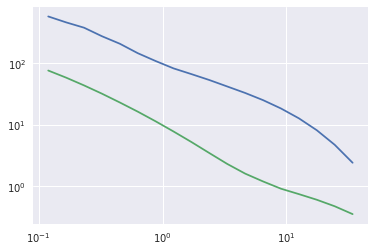

In [144]:
plt.plot(emu.scale_bin_centers, true_data[0])
plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [145]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [146]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

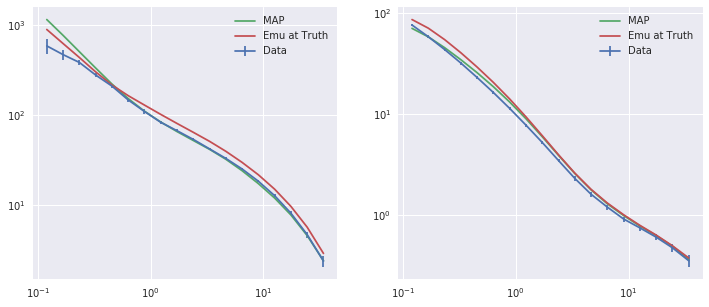

In [147]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, 10**true_pred, label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

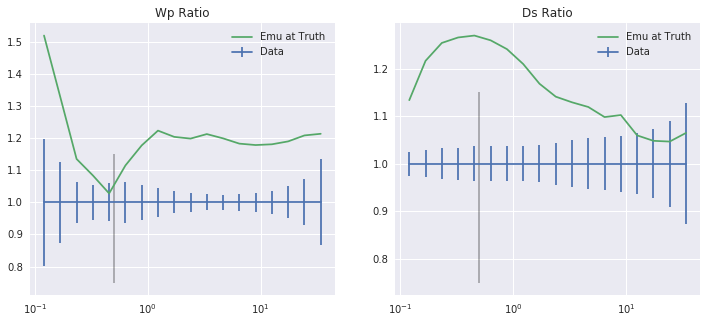

In [148]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    if i == 0:
        plt.title('Wp Ratio')
    else:
        plt.title('Ds Ratio')
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    #plt.plot(rbc, (10**MAP_pred[i])/true_data[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred)/true_data[i], label = 'Emu at Truth')
    plt.vlines(0.5, 0.75, 1.15, alpha = 0.3)
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [149]:
emu.obs

'ds'

In [150]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [151]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [152]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

In [153]:
rmin_idxs = rbc > rmin

In [154]:
cov_rmin_idxs = np.r_[rmin_idxs, rmin_idxs]

In [155]:
print 'True Red. Chi2'
R = (10**true_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
19.00676529846039


In [156]:
print 'Map Red. Chi2'
R = (10**MAP_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
12.133720002054078


In [157]:
N = 10
cmap = sns.color_palette("BrBG_d", N)

In [158]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias']

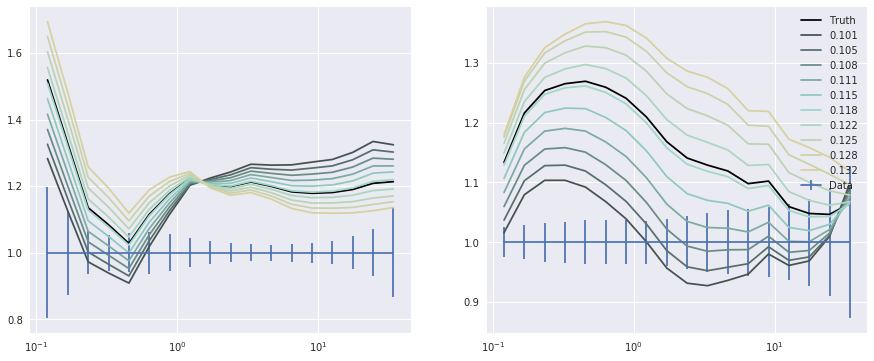

In [159]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'omch2'
lower, upper = emu.get_param_bounds(varied_pname)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    pred = emus[i].emulate_wrt_r(true_param_dict.copy()).squeeze()
    if i ==1:
        const = 1#np.power(MAP_dict['H0']/(100*h), 2)
    else:
        const = 1
    plt.plot(rbc, const*(10**pred)/true_data[i], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = true_param_dict.copy() #true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        if i ==1:
            const = 1#np.power(val/(100*h), 2)
        else:
            const= 1 #np.power(val/(100*h), 1)
        plt.plot(rbc, const*((10**pred)/(true_data[i])), label = '%.3f'%val, color = c)
    
plt.legend(loc='best')
plt.show();